In [1]:
from sympy import *
import sympy
import scipy.integrate
import casadi
from casadi import inf
init_printing()
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


In [2]:
# Define symbols for use with SymPy
# Non-symbolic versions of these (floating point usually) are denoted with an underscore before or after
x, y, z, theta, r, r_pulley, theta1, A, C, theta_max, H, n =\
symbols('x y z theta r r_pulley theta1 A C theta_max H, n')

# Define parametric equations of winches

def winch1_with_r(r):
    return [r * cos(theta),
            r * sin(theta),
            A * theta]

def winch2_with_r(r):
    return [r * (cos(-theta)),
            r * (sin(-theta)),
            A * (-theta)]

winch2_with_r(Function('r')(theta)) # print out winch2


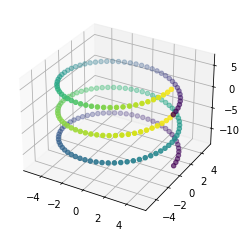

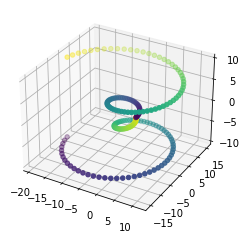

In [3]:
def plot_winch(r_1, theta_now, name, _theta_max=6*np.pi):

    winch1_evaled = [ [winch.evalf(subs={A: 1.0, theta: _theta})
                       for _theta in np.arange(0, theta_now, 0.1)]
                       for winch in winch1_with_r(r_1)]

    winch2_evaled = [ [winch.evalf(subs={A: 1.0, theta: _theta})
                       for _theta in np.arange(0, _theta_max - theta_now, 0.1)]
                       for winch in winch2_with_r(r_1)]

    plt.close(name)
    fig = plt.figure(name)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*winch1_evaled, c=winch1_evaled[2])
    ax.scatter(*winch2_evaled, c=winch2_evaled[2])
    
plot_winch(5.0, 2*np.pi, 'Constant Radius')
plot_winch((1 + theta + .1*theta**2), 3*np.pi, 'Variable Radius')


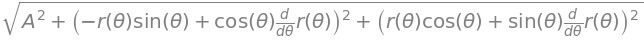

In [4]:
def dL_parametric(parametric_eq):
    # Derivative of the length of a parametric equation (integrate to get length)
    return sqrt(
        Derivative(parametric_eq[0], theta)**2 +
        Derivative(parametric_eq[1], theta)**2 +
        Derivative(parametric_eq[2], theta)**2
    )

dL_parametric(winch1_with_r(Function(r)(theta))).doit() # d/dtheta(Lwinch1) for a generalized r

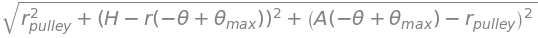

In [5]:
# Define expressions for length of middle cables

def Lmiddle1_with_r(r):
    return sqrt((A*theta - r_pulley)**2 + (H - r)**2 + r_pulley**2)

def Lmiddle2_with_r(r):
    return Lmiddle1_with_r(r).subs(theta, theta_max - theta)

Lmiddle2_with_r(Function('r')(theta))

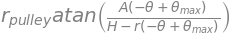

In [6]:
def Larc1_with_r(r):
    return r_pulley * atan(A*theta / (H - r))

def Larc2_with_r(r):
    return Larc1_with_r(r).subs(theta, theta_max - theta)

Larc2_with_r(Function('r')(theta))

In [7]:
# Create a polynomial sequence of desired order
order = 1
a = symbols('a:{}'.format(order+1))
R = symbols('R')
R = a[0]
for i in range(1, order+1):
    R += a[i] * theta**i
R


In [8]:
# # Create linear R with sine
# order = 4
# a = symbols('a:{}'.format(order+1))
# R = symbols('R')
# R = a[0] + a[1] * theta + a[2] * sin(a[4]*theta) + a[3] * cos(a[4]*theta)
# R


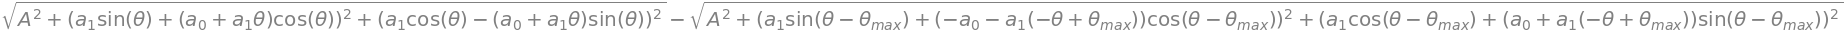

In [9]:
dLtotalWinch = dL_parametric(winch1_with_r(R)).doit() - dL_parametric(winch2_with_r(R)).doit().subs(theta, theta_max - theta)
dLtotalWinch

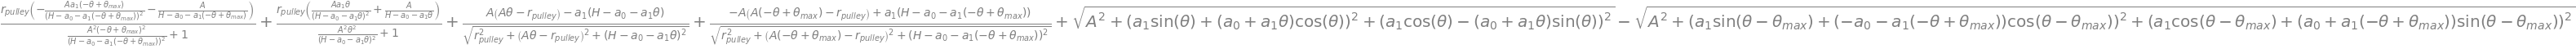

In [10]:
dLtotal = (dLtotalWinch
           + diff(Lmiddle1_with_r(R), theta)
           + diff(Lmiddle2_with_r(R), theta)
           + diff(Larc1_with_r(R), theta)
           + diff(Larc2_with_r(R), theta)
          )
dLlam = lambdify([theta, A, H, theta_max, a], dLtotal)
R_lam = lambdify([a, theta], R, "sympy")
dLtotal


In [11]:
def sympy2casadi(sympy_expr,sympy_var,casadi_var):
  import casadi
  assert casadi_var.is_vector()
  if casadi_var.shape[1]>1:
    casadi_var = casadi_var.T
  casadi_var = casadi.vertsplit(casadi_var)
  from sympy.utilities.lambdify import lambdify

  mapping = {'ImmutableDenseMatrix': casadi.blockcat,
             'MutableDenseMatrix': casadi.blockcat,
             'Abs':casadi.fabs
            }
  f = lambdify(sympy_var, sympy_expr, modules=[mapping, casadi])
  #print(casadi_var)
  return f(*casadi_var)


In [37]:
# Run optimization
dtheta = 1
theta_max_ = 15*np.pi
A_ = 1.0
H_ = 40.0
r_pulley_ = 10.0
min_radius = 5.0
max_radius = 8.0
a_0 = [5] # arbitrary non-zero constant radius
for i in range(order):
    a_0.append(0)

theta_range = np.arange(0, theta_max_, dtheta)

print("making objective function")
#objective = 0
radius_constraint = []
dLtotal_with_constants = dLtotal.subs({A: A_,
                                       H: H_,
                                       theta_max: theta_max_,
                                       r_pulley: r_pulley_
                                      })
dLtotal_lam = lambdify(theta, dLtotal_with_constants, "sympy")
a_casadi = casadi.SX.sym('a', order+1)

objective_vec = casadi.SX(len(theta_range),1)
print(objective_vec)

for index, theta_ in enumerate(theta_range):
    #objective = objective + dLtotal_with_constants.subs({theta: theta_}) ** 2
    objective_vec[index] = sympy2casadi(dLtotal_lam(theta_), a, a_casadi)
    radius_constraint.append(
        sympy2casadi(R_lam(a, theta_), a, a_casadi))

#print(objective_vec)
objective = casadi.norm_2(objective_vec)
#print(objective)

#print("converting sympy2casadi")
#obj_casadi = sympy2casadi(objective, a, a_casadi)

making objective function
[00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00, 00]


In [38]:
a_0

In [39]:
nlp = {'x': a_casadi, 'f': objective, 'g': casadi.vertcat(*radius_constraint)}

print("creating ipopt solver")
S = casadi.nlpsol('S', 'ipopt', nlp)
print(S)
print("solving")
res = S(x0=a_0,
        lbg=[min_radius]*len(radius_constraint),
        ubg=[max_radius]*len(radius_constraint),
        lbx=[-inf, -inf],
        ubx=[+inf, +inf]
       )

creating ipopt solver
S:(x0[2],p[],lbx[2],ubx[2],lbg[48],ubg[48],lam_x0[2],lam_g0[48])->(x[2],f,g[48],lam_x[2],lam_g[48],lam_p[]) IpoptInterface
solving
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       95
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       48
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       48

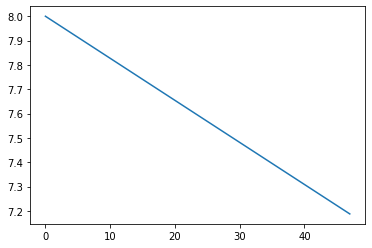

In [40]:
res_x = np.array(res['x'].full()).T[0]
plt.close('result-R')
plt.figure('result-R')
R_opt = lambdify(theta, R_lam(res_x, theta))
x = np.arange(0, theta_max_, dtheta)
R_plt = [R_opt(theta) for theta in x]
plt.plot(x, R_plt)


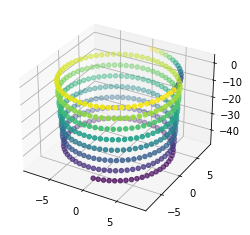

In [41]:
plot_winch(R_lam(res_x, theta), .5*np.pi, 'Result Winch', _theta_max=theta_max_)


Constant radius ([5, 0]): Change in length from 0 to 47.12rad:   9.520958147942224
Optimized radius: Change in length from 0 to 47.12rad:   0.03673076521454277


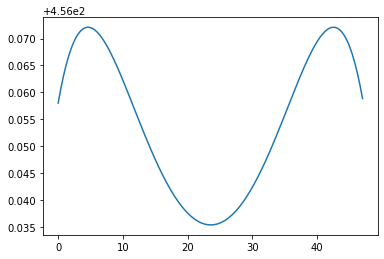

In [42]:
subs = {
    A: A_,
    H: H_,
    theta_max: theta_max_,
    r_pulley: r_pulley_    
    }
dLwinch1 = dL_parametric(winch1_with_r(R)).doit()
dLwinch1_lam = lambdify([theta, a], dLwinch1.subs(subs))
dLwinch2 = dL_parametric(winch2_with_r(R)).doit()
dLwinch2_lam = lambdify([theta, a], dLwinch2.subs(subs))
theta_range = np.arange(0, theta_max_, 0.2)

def compute_lengths_res(a_to_use):

    Lwinch1_res = np.array([scipy.integrate.quad(lambda x: dLwinch1_lam(x, a_to_use), 0, theta_now)[0]
                            for theta_now in theta_range])
    Lwinch2_res = np.array([scipy.integrate.quad(lambda x: dLwinch2_lam(x, a_to_use), 0, theta_max_ - theta_now)[0]
                            for theta_now in theta_range])
    Lmiddle1_res = np.array([lambdify([theta, a], Lmiddle1_with_r(R).subs(subs))(theta_now, a_to_use)
                             for theta_now in theta_range])
    Lmiddle2_res = np.array([lambdify([theta, a], Lmiddle2_with_r(R).subs(subs))(theta_now, a_to_use)
                             for theta_now in theta_range])
    Larc1_res = np.array([lambdify([theta, a], Larc1_with_r(R).subs(subs))(theta_now, a_to_use)
                             for theta_now in theta_range])
    Larc2_res = np.array([lambdify([theta, a], Larc2_with_r(R).subs(subs))(theta_now, a_to_use)
                             for theta_now in theta_range])

    return (Lmiddle1_res + Lmiddle2_res + Lwinch1_res + Lwinch2_res + Larc1_res + Larc2_res)

Ltotal_constantradius = compute_lengths_res(a_0)
Ltotal_res = compute_lengths_res(res_x)
print(f"Constant radius ({a_0}): Change in length from 0 to {theta_max_:.2f}rad:   {np.max(Ltotal_constantradius) - np.min(Ltotal_constantradius)}")
print(f"Optimized radius: Change in length from 0 to {theta_max_:.2f}rad:   {np.max(Ltotal_res) - np.min(Ltotal_res)}")

# plt.close('Lmiddle1, Lmiddle2')
# plt.figure('Lmiddle1, Lmiddle2')
# plt.plot(theta_range, Lmiddle1_res)
# plt.plot(theta_range, Lmiddle2_res)

# plt.close('Lwinch1, Lwinch2')
# plt.figure('Lwinch1, Lwinch2')
# plt.plot(theta_range, Lwinch1_res)
# plt.plot(theta_range, Lwinch2_res)

plt.close('Ltotal')
plt.figure('Ltotal')
plt.plot(theta_range, Ltotal_res)
#plt.plot(theta_range, Lwinch2_res)

In [43]:
res_x


array([ 7.99999742, -0.01727795])